- [assignments 1 page](https://www.csie.ntu.edu.tw/~cyy/courses/vfx/22spring/assignments/proj1/)
- Author: R10944007 曾宏鈞, 許博翔 

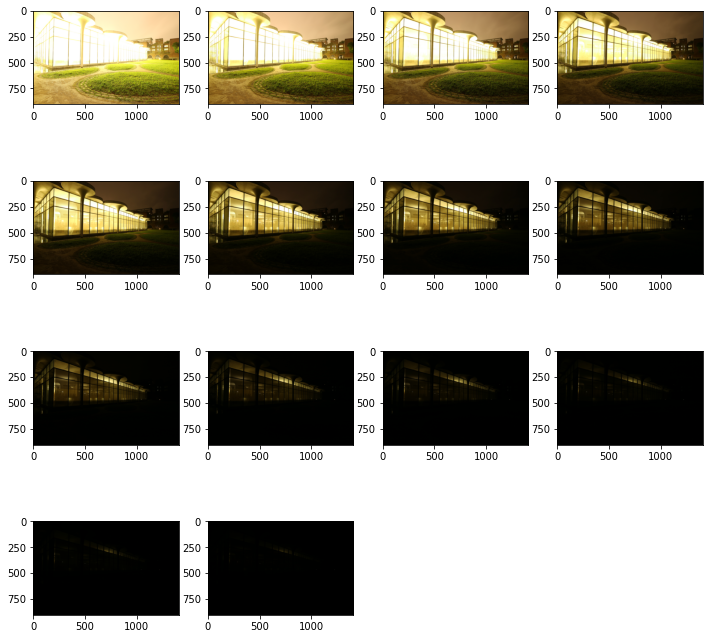

In [96]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import math

# path = "../data/Memorial_SourceImages/*png"
path = "./output/social/*JPG"
files = glob.glob(path)
files.sort(reverse=False)
raw_images = [cv2.resize(cv2.imread(f), (1440, 960), interpolation = cv2.INTER_AREA) for f in files][:14]
# raw_images = [cv2.imread(f) for f in files]
images = [image[32:-24, 16:-16] for image in raw_images]

shutter_speed = np.array([1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024][:14])

plt.figure(figsize=(12,12))
for i in range(len(images)):
    plt.subplot(4, math.ceil(len(images)/4), i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))

In [97]:
## 這邊不確定可不可以直接使用cv2.resize
sample = [] #np.array(image_shifted.copy())
for i in range(len(images)):
    sample.append( cv2.resize(images[i], (10, 10), interpolation = cv2.INTER_AREA) )
sample = np.array(sample)

print(sample.shape)
sample = np.transpose(sample, (3, 1, 2, 0))
sample = sample.reshape((sample.shape[0], sample.shape[1]*sample.shape[2], sample.shape[3]))
print(sample.shape) # (bgr channels, pixels, pictures)

(14, 10, 10, 3)
(3, 100, 14)


In [98]:
# Weight functions
mu = np.mean(range(256))
sigma = np.std(range(256))
# Normal distribution pdf
normal = lambda x: (1 / (sigma * (2 * np.pi)**0.5)) * np.exp( (-1/2) * (((x - mu) /sigma)**2))
# None
none = lambda x: x

# 1/Distance
distance = lambda x: mu - abs(x - mu)

In [99]:
# recover camera response curve
# Paul Debevec's method
# return camera response function g
# 解 Ax=b np.linalg.lstsq(A, b)

# Arguments
"""
Input:
    Z: i pixel in j image
    B: log(delta t)
    l: constant of smoothness
    w: weight of pixel z
Output:
    g(z)
    lE(i)
"""
shutter_time = 1/shutter_speed
B = np.log(shutter_time)
l = 100 # 我隨便設
w = normal


In [100]:
# gsolve(Z, B, l, w)
def gsolve(Z, B, l, w):
   
    n = 256
    A = np.zeros((Z.shape[0]*Z.shape[1]+(n-2)+1, n+Z.shape[0]), dtype=np.float32)
    b = np.zeros((A.shape[0], 1), dtype=np.float32)
    W = np.zeros(Z.shape, dtype=np.float32)


    ## 算np
    k=0
    for i in range(0, Z.shape[0]):
        for j in range(0, Z.shape[1]):
            W[i][j] = w(Z[i][j])
            A[k][ Z[i][j] ] = W[i][j]
            A[k][n+i] = -W[i][j]
            b[k][0] = W[i][j] * B[j]
            k+=1

    A[k][127] = 1
    k+=1

    for i in range(0, n-2):
        weight = w(i+1)
        A[k][i] = l * weight
        A[k][i+1] = -2 * l*weight
        A[k][i+2] = l * weight
        k+=1

    print(A.shape, b.shape)
    from scipy.linalg import lstsq
    x = lstsq(A, b)

    g=x[0][:n]
    lE = x[0][n:]
    print(g.shape, lE.shape)
    return g, lE

gs, lEs = [], []
for i in range(3):
    Z = sample[i]
    print(Z.shape)
    g, lE = gsolve(Z, B, l, w)
    gs.append(g)
    lEs.append(lE)


(100, 14)
(1655, 356) (1655, 1)
(256, 1) (100, 1)
(100, 14)
(1655, 356) (1655, 1)
(256, 1) (100, 1)
(100, 14)
(1655, 356) (1655, 1)
(256, 1) (100, 1)


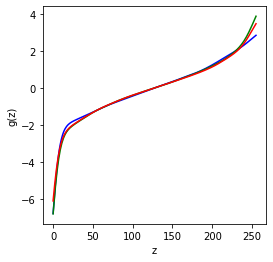

In [101]:
colors = ["blue", "green", "red"]
plt.figure(figsize=(4, 4))
for i in range(3):
    plt.plot(range(256), gs[i], color=colors[i])
plt.xlabel("z")
plt.ylabel("g(z)")
plt.show()

In [102]:
def construct_radiance_map(images, B, gs, w):
    w_map = [w(x) for x in range(256)]
    shape = images[0].shape
    images = np.array(images)
    weights = np.vectorize(lambda x: w_map[x])(images)
    w_t = np.sum(weights, axis=0)
    def get_g(x):
        a = np.zeros(3)
        a[0] = gs[0][x[0]]
        a[1] = gs[1][x[1]]
        a[2] = gs[2][x[2]]
        return a
    lnE_raw = np.apply_along_axis(get_g, 3, images) - np.array([np.ones(shape) * t for t in B])
    sum = np.sum(weights * lnE_raw, axis=0)
    return sum / w_t

In [103]:
ln_radiance_map = construct_radiance_map(raw_images, B, gs, w)

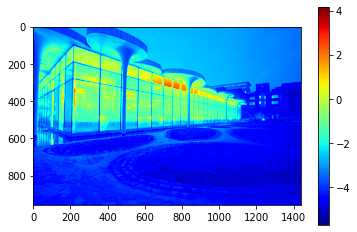

In [104]:
plt.imshow(ln_radiance_map[:,:,0], cmap="jet")
plt.colorbar()

In [105]:
radiance_map = np.exp(ln_radiance_map)
cv2.imwrite('social2.hdr', radiance_map.astype(np.float32))

True

# Ref
1. Ward, G. (2003). Fast, robust image registration for compositing high dynamic range photographs from hand-held exposures. Journal of graphics tools, 8(2), 17-30.